# Creating Toy Datasets from MPTrj Systematically

## Download MPTrj Data

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from urllib.request import urlretrieve
from pymatgen.core import Element

path_data = Path("./data")
path_data.mkdir(exist_ok=True)
url = "https://github.com/ACEsuit/mace-mp/releases/download/mace_mp_0b/mp_traj_combined.xyz"
path_mp_traj = path_data/url.split("/")[-1] 
path_mp_traj

PosixPath('data/mp_traj_combined.xyz')

In [2]:
element_strings = [str(Element.from_Z(i+1)) for i in range(118)] ; element_strings[:10]

['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne']

In [3]:
if not path_mp_traj.exists():  
    urlretrieve(url, path_mp_traj)
    
mp_traj = read(path_mp_traj, index="0:"); len(mp_traj)

145923

In [4]:
{*mp_traj[0].get_chemical_symbols()}

{'Bi', 'O', 'W'}

In [5]:
idx_to_elements = {i: set(atoms.get_chemical_symbols()) for i, atoms in enumerate(mp_traj)}

element_to_idxs = {}
for element in element_strings:
    element_to_idxs[element] = {i for i, atoms in idx_to_elements.items() if element in atoms}

In [6]:
counts = {element: len(idxs) for element, idxs in element_to_idxs.items()}

## Element Distribution Analysis

In [7]:
def plot_bar(dict, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    ax.bar(range(len(dict)), list(dict.values()), align='center')
    ax.set_xticks(range(len(dict)), list(dict.keys()))

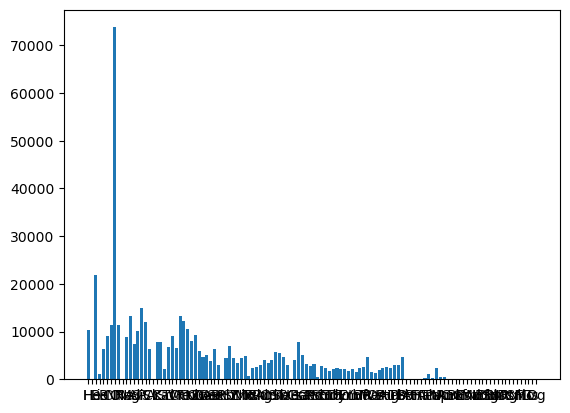

In [8]:
plot_bar(counts)

## Sampling Material IDs
Let's get the "target" distribution

In [9]:
selected_elements = [str(Element.from_Z(i+1)) for i in range(18)] # to Argon

In [10]:
num_materials = 10000
low_count = num_materials // len(selected_elements) # this may be undesirable if num_materials is close to len(mp_traj)

In [11]:
# add "rare" (low count) elements to training set
sampled_idxs = set()
for element in selected_elements:
    if counts[element] < low_count:
        sampled_idxs.update(element_to_idxs[element])

# add the remainder of the elements
remaining_idxs = set(range(len(mp_traj))).difference(sampled_idxs)
sampled_idxs.update(np.random.choice(list(remaining_idxs), size=num_materials-len(sampled_idxs), replace=False))

selected_counts = {}
for element in selected_elements:
    selected_counts[element] = len([idx for idx in sampled_idxs if element in idx_to_elements[idx]])

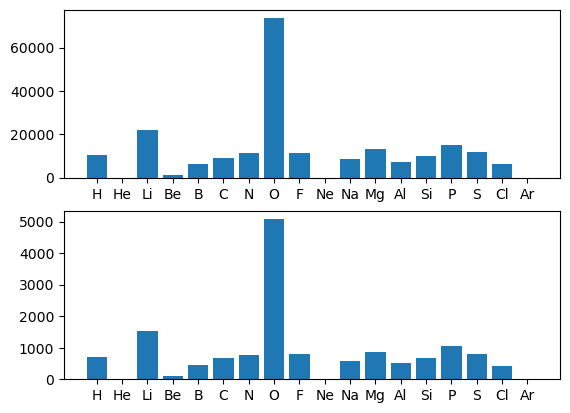

In [12]:
fig, ax = plt.subplots(2)
plot_bar({element: count for element, count in counts.items() if element in selected_elements}, ax=ax[0])
plot_bar(selected_counts, ax=ax[1])

In [13]:
selected_counts, {element: count for element, count in counts.items() if element in selected_elements}

({'H': 702,
  'He': 8,
  'Li': 1515,
  'Be': 95,
  'B': 452,
  'C': 665,
  'N': 765,
  'O': 5073,
  'F': 809,
  'Ne': 1,
  'Na': 575,
  'Mg': 868,
  'Al': 504,
  'Si': 684,
  'P': 1066,
  'S': 807,
  'Cl': 419,
  'Ar': 2},
 {'H': 10312,
  'He': 8,
  'Li': 21802,
  'Be': 1179,
  'B': 6330,
  'C': 9043,
  'N': 11356,
  'O': 73799,
  'F': 11277,
  'Ne': 1,
  'Na': 8782,
  'Mg': 13360,
  'Al': 7374,
  'Si': 10059,
  'P': 14873,
  'S': 11972,
  'Cl': 6273,
  'Ar': 2})

## Find task ID for Ni, NiO

In [31]:
for atoms in mp_traj:
    formula = atoms.get_chemical_formula()
    if formula == 'Ni':
        print('Ni:', atoms.info['task_id'])
    if formula == 'NiO':
        print('NiO:', atoms.info['task_id'])

Ni: mp-906274
NiO: mp-1427846
Ni: mp-1008739
Ni: mp-1871491
